# Dataset Preview
How the data looks:
- Total 14 columns present
- Multiple sentiment categories are also present

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv')

# Show basic structure
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [3]:
df.info()
df['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


Sentiment
Positive            44
Joy                 42
Excitement          32
Contentment         14
Happy               14
                    ..
Loneliness           1
Anxiety              1
Renewed Effort       1
Miscalculation       1
Challenge            1
Name: count, Length: 279, dtype: int64

# Data Pre-processing & Cleaning

In [10]:
df = df[['Text', 'Sentiment']]  # Keeping only the important columns
df = df[df['Sentiment'].str.strip() != '']  # Remove empty sentiment labels
df = df.drop_duplicates()
df['Sentiment'] = df['Sentiment'].str.strip().str.title()  # Standardize text

import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove special chars
    return text.lower().strip()

df['Clean_Text'] = df['Text'].apply(clean_text)

# Data Visualization

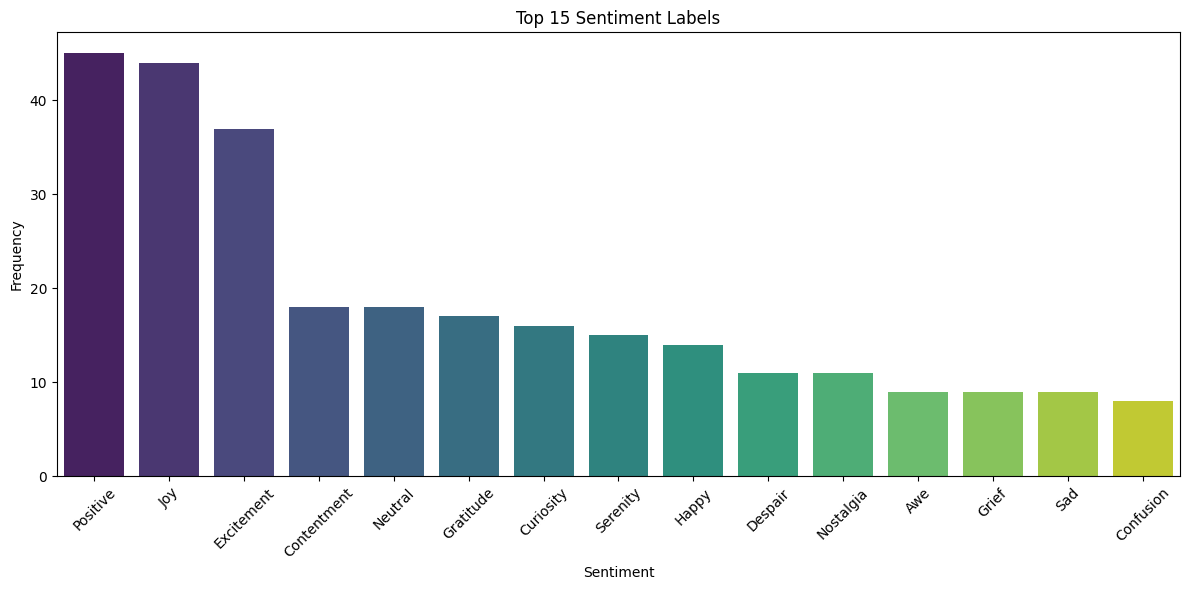

In [5]:
#Plot sentiment freuqencies
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 sentiments only (because we have too many!)
top_sentiments = df['Sentiment'].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_sentiments.index, y=top_sentiments.values, palette='viridis')
plt.title('Top 15 Sentiment Labels')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()


In [28]:
# Define lists of positive and negative sentiments (adjust as needed)
positive_sentiments = ['Positive', 'Joy', 'Excitement', 'Contentment', 'Happy', 'Love', 'Gratitude', 'Optimism', 'Relief']
negative_sentiments = ['Negative', 'Anger', 'Sadness', 'Fear', 'Anxiety', 'Disgust', 'Frustration', 'Loneliness', 'Guilt']

# Create a new column 'Polarity' based on these lists
def polarity_map(sentiment):
    if sentiment in positive_sentiments:
        return 'Positive'
    elif sentiment in negative_sentiments:
        return 'Negative'
    else:
        return None  # ignore neutral or unknown sentiments

df['Polarity'] = df['Sentiment'].apply(polarity_map)

# Drop rows with None polarity (neutral or unknown)
df_binary = df.dropna(subset=['Polarity'])

# Text Vectorization

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df_binary['Clean_Text'])

le = LabelEncoder()
y = le.fit_transform(df_binary['Polarity'])  # Positive=1, Negative=0 (or vice versa)

# Training

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Random Forest Accuracy: 0.8372093023255814
              precision    recall  f1-score   support

    Negative       1.00      0.12      0.22         8
    Positive       0.83      1.00      0.91        35

    accuracy                           0.84        43
   macro avg       0.92      0.56      0.57        43
weighted avg       0.86      0.84      0.78        43



# Visualize classifications and misclassifications

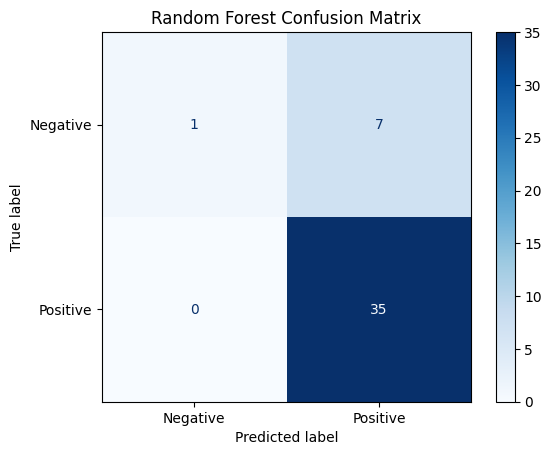

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

In [33]:
# We need to get the test set indices from the train_test_split to align texts correctly
# When you did train_test_split, you can do it like this to keep track of indices:

from sklearn.model_selection import train_test_split

# Assuming your df_binary['Clean_Text'] and y are defined

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df_binary.index, test_size=0.2, random_state=42
)

# After prediction, use test_idx to get the texts
results_df = pd.DataFrame({
    'Text': df_binary.loc[test_idx, 'Clean_Text'].values,
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(y_pred)
})

results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

print("First 10 predictions (misclassifications marked):\n")
print(results_df.head(10))

print("\nMisclassified samples:\n")
print(results_df[~results_df['Correct']].head(10))

First 10 predictions (misclassifications marked):

                                                Text    Actual Predicted  \
0                winter sports day at the local park  Positive  Positive   
1  bonding with friends over the latest kpop sens...  Positive  Positive   
2  sipping on a favorite vintage wine each sip te...  Positive  Positive   
3      disgust at the sight of injustice and cruelty  Negative  Positive   
4  sending love to all my followers on this beaut...  Positive  Positive   
5  successfully fundraising for a school charity ...  Positive  Positive   
6            feeling optimistic about the week ahead  Positive  Positive   
7  planning a surprise scavenger hunt for friends...  Positive  Positive   
8              feeling a bit under the weather today  Negative  Positive   
9  in the garden of contentment each bloom whispe...  Positive  Positive   

   Correct  
0     True  
1     True  
2     True  
3    False  
4     True  
5     True  
6     True  
7     Tr

# Interpretability through SHAP

SHAP summary plot for class: Negative


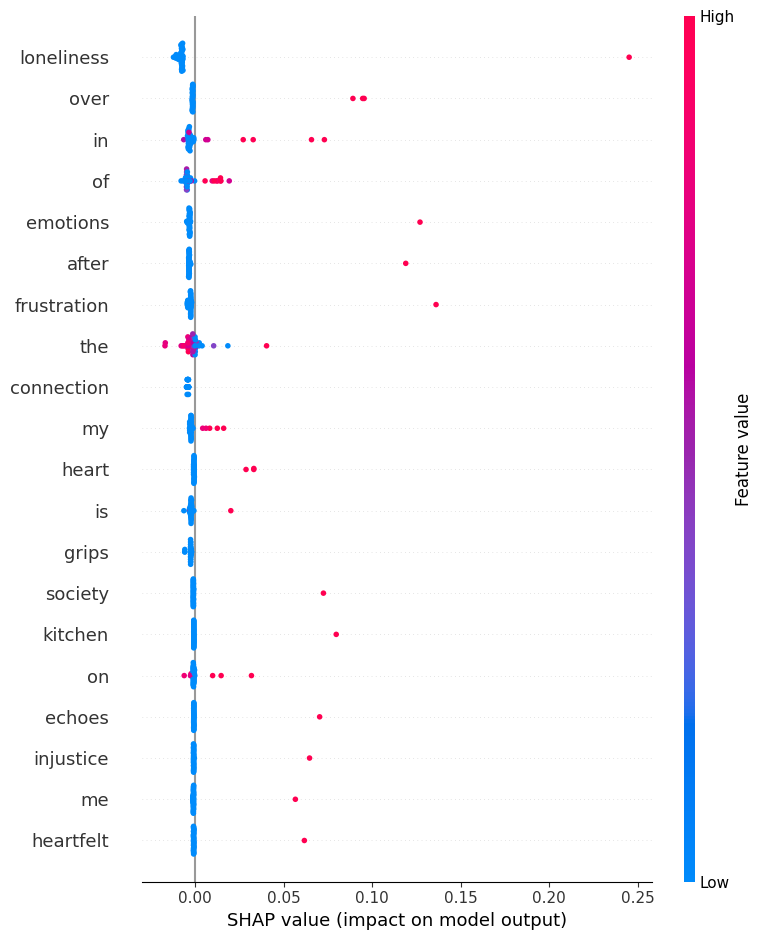

In [36]:
import shap

# Convert sparse matrix to dense
X_test_dense = X_test.toarray()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_dense)

shap.initjs()
for i, class_name in enumerate(le.classes_):
    print(f"SHAP summary plot for class: {class_name}")
    shap.summary_plot(shap_values[i], X_test_dense, feature_names=tfidf.get_feature_names_out())
    break # I only want it for negative class